In [ ]:
import pandas as pd
import numpy as np
import seaborn as sb
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error , r2_score, root_mean_squared_error
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsforecast import StatsForecast
from statsforecast.models import Naive, SeasonalNaive, SeasonalWindowAverage, AutoARIMA
from prophet import Prophet


# Carregar os dados
url = 'https://raw.githubusercontent.com/jdlmauricio/techalleg_fase_2/refs/heads/main/Dados%20Hist%C3%B3ricos%20-%20Ibovespa.csv'
indice_ibov = pd.read_csv(url, parse_dates=[0], index_col='Data')

datas_completas = pd.date_range(start=indice_ibov.index.min(), end=indice_ibov.index.max(), freq= 'D')
indice_ibov = indice_ibov.reindex(datas_completas)
indice_ibov.index.name = 'Data'

# Visualizar os primeiros registros
indice_ibov.head()


C:\Users\pedro\AppData\Local\Temp\ipykernel_18608\1905036841.py:19: UserWarning: Parsing dates in %d.%m.%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  indice_ibov = pd.read_csv(url, parse_dates=[0], index_col='Data')


,Último,Abertura,Máxima,Mínima,Vol.,Var%
Data,,,,,,
2005-01-03,25.722,26.193,26.492,25.671,"115,64M","-1,81%"
2005-01-04,24.848,25.722,25.873,24.791,"146,14M","-3,40%"
2005-01-05,24.692,24.859,25.001,24.523,"127,42M","-0,63%"
2005-01-06,24.367,24.695,24.808,24.250,"151,17M","-1,32%"
2005-01-07,24.747,24.376,24.874,24.376,"104,96M","1,56%"


In [2]:
indice_ibov = indice_ibov.fillna(method='ffill')

C:\Users\pedro\AppData\Local\Temp\ipykernel_18608\2523758291.py:1: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  indice_ibov = indice_ibov.fillna(method='ffill')


In [3]:
indice_ibov.head(2)


,Último,Abertura,Máxima,Mínima,Vol.,Var%
Data,,,,,,
2005-01-03,25.722,26.193,26.492,25.671,"115,64M","-1,81%"
2005-01-04,24.848,25.722,25.873,24.791,"146,14M","-3,40%"


In [4]:
indice_ibov['Vol.'] = indice_ibov['Vol.'].str.replace(',', '', regex=False)
indice_ibov['Vol.'] = indice_ibov['Vol.'].str.replace('M', '0000', regex=False)
indice_ibov['Vol.'] = indice_ibov['Vol.'].str.replace('K', '', regex=False)
indice_ibov['Var%'] = indice_ibov['Var%'].str.replace('%', '', regex=False)
indice_ibov['Var%'] = indice_ibov['Var%'].str.replace(',', '.', regex=False)


# Verificando os primeiros valores para verificação
indice_ibov.tail()

,Último,Abertura,Máxima,Mínima,Vol.,Var%
Data,,,,,,
2024-12-26,121.078,120.767,121.612,120.428,8340000,0.26
2024-12-27,120.269,121.078,121.609,120.252,8940000,-0.67
2024-12-28,120.269,121.078,121.609,120.252,8940000,-0.67
2024-12-29,120.269,121.078,121.609,120.252,8940000,-0.67
2024-12-30,120.283,120.267,121.050,120.158,8900000,0.01


In [5]:
df_novo = indice_ibov
df_novo = df_novo.reset_index()
df_novo['unique_id'] = 0
df_pf = df_novo[['unique_id','Data', 'Abertura', 'Último', 'Máxima', 'Mínima', 'Vol.', 'Var%' ]]
df_novo = df_novo[['unique_id','Data','Abertura', 'Último', 'Máxima', 'Mínima', 'Vol.', 'Var%' ]]

In [6]:
df_pf.rename({"Último": "fechamento"}, inplace=True, axis=1)
df_pf.rename({"Abertura": "abertura"}, inplace=True, axis=1)
df_pf.rename({"Máxima": "alta"}, inplace=True, axis=1)
df_pf.rename({"Mínima": "baixa"}, inplace=True, axis=1)
df_pf.rename({"Vol.": "vol"}, inplace=True, axis=1)
df_pf.rename({"Var%": "var%"}, inplace=True, axis=1)

###propet

In [7]:
df_pf.head()

,unique_id,Data,abertura,fechamento,alta,baixa,vol,var%
0,0,2005-01-03,26.193,25.722,26.492,25.671,115640000,-1.81
1,0,2005-01-04,25.722,24.848,25.873,24.791,146140000,-3.40
2,0,2005-01-05,24.859,24.692,25.001,24.523,127420000,-0.63
3,0,2005-01-06,24.695,24.367,24.808,24.250,151170000,-1.32
4,0,2005-01-07,24.376,24.747,24.874,24.376,104960000,1.56


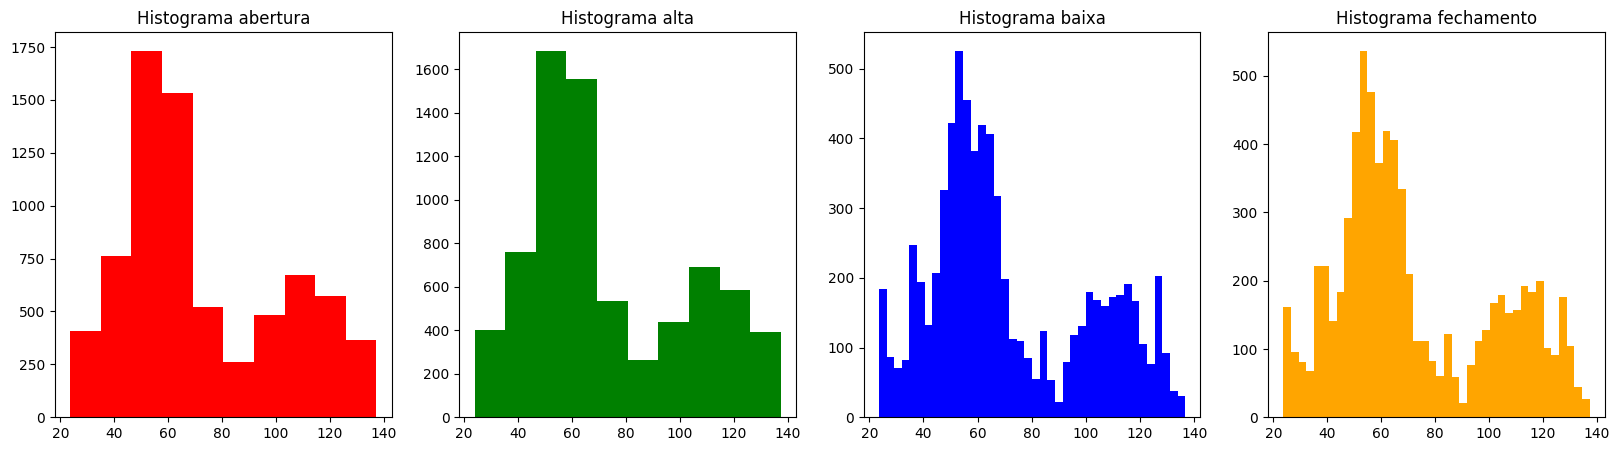

In [8]:
#new_fig = plt.figure(figsize=(18,8))
new_fig = plt.figure(figsize=(20,5))

#((5,4), (0,0))
ax1 = plt.subplot2grid((1,4), (0,0))
ax2 = plt.subplot2grid((1,4), (0,1))
ax3 = plt.subplot2grid((1,4), (0,2))
ax4 = plt.subplot2grid((1,4), (0,3))

ax1.hist(df_pf['abertura'], color='red',bins=10)
ax2.hist(df_pf['alta'], color='green',bins=10)
ax3.hist(df_pf['baixa'], color='blue',bins=40);
ax4.hist(df_pf['fechamento'], color='orange',bins=40)

ax1.set_title('Histograma abertura')
ax2.set_title('Histograma alta')
ax3.set_title('Histograma baixa')
ax4.set_title('Histograma fechamento')

plt.show()

In [9]:
historico = df_pf.copy()

def rolling_column_std( df, column_name, days,exclude=True ):
    column_name_hist = "std_%s_%sd" % (column_name, days)
    df[column_name_hist] = df[column_name].rolling(days).std().round(2)
    if exclude:
        df.drop([column_name], axis='columns', inplace=True)

rolling_column_std(historico,'abertura', 5, False)
rolling_column_std(historico,'fechamento', 5, False)
rolling_column_std(historico,'vol', 5, False)
rolling_column_std(historico,'alta', 5, False)
rolling_column_std(historico,'baixa', 5, False)

rolling_column_std(historico,'abertura', 10, False)
rolling_column_std(historico,'fechamento', 10, False)
rolling_column_std(historico,'vol', 10, False)
rolling_column_std(historico,'alta', 10, False)
rolling_column_std(historico,'baixa', 10,  False)

historico

,unique_id,Data,abertura,fechamento,alta,baixa,vol,var%,std_abertura_5d,std_fechamento_5d,std_vol_5d,std_alta_5d,std_baixa_5d,std_abertura_10d,std_fechamento_10d,std_vol_10d,std_alta_10d,std_baixa_10d
0,0,2005-01-03,26.193,25.722,26.492,25.671,115640000,-1.81,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,2005-01-04,25.722,24.848,25.873,24.791,146140000,-3.40,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0,2005-01-05,24.859,24.692,25.001,24.523,127420000,-0.63,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0,2005-01-06,24.695,24.367,24.808,24.250,151170000,-1.32,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,2005-01-07,24.376,24.747,24.874,24.376,104960000,1.56,0.76,0.51,19647991.75,0.74,0.57,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7297,0,2024-12-26,120.767,121.078,121.612,120.428,8340000,0.26,0.64,0.58,3901010.13,0.24,0.10,1.28,1.23,4433083.20,1.27,0.94
7298,0,2024-12-27,121.078,120.269,121.609,120.252,8940000,-0.67,0.66,0.29,748217.88,0.27,0.16,1.17,0.67,4576595.53,0.89,0.16
7299,0,2024-12-28,121.078,120.269,121.609,120.252,8940000,-0.67,0.63,0.35,706562.10,0.27,0.18,0.54,0.72,4197478.61,0.27,0.19
7300,0,2024-12-29,121.078,120.269,121.609,120.252,8940000,-0.67,0.51,0.37,580189.62,0.22,0.16,0.51,0.77,4304888.69,0.29,0.20


In [10]:
historico.isnull().sum()

unique_id             0
Data                  0
abertura              0
fechamento            0
alta                  0
baixa                 0
vol                   0
var%                  0
std_abertura_5d       4
std_fechamento_5d     4
std_vol_5d            4
std_alta_5d           4
std_baixa_5d          4
std_abertura_10d      9
std_fechamento_10d    9
std_vol_10d           9
std_alta_10d          9
std_baixa_10d         9
dtype: int64

In [11]:
historico.dropna(subset=['std_abertura_5d'], inplace=True)
historico.dropna(subset=['std_abertura_10d'], inplace=True)
historico.dropna(subset=['std_fechamento_5d'], inplace=True)
historico.dropna(subset=['std_fechamento_10d'], inplace=True)
historico.isnull().sum()

unique_id             0
Data                  0
abertura              0
fechamento            0
alta                  0
baixa                 0
vol                   0
var%                  0
std_abertura_5d       0
std_fechamento_5d     0
std_vol_5d            0
std_alta_5d           0
std_baixa_5d          0
std_abertura_10d      0
std_fechamento_10d    0
std_vol_10d           0
std_alta_10d          0
std_baixa_10d         0
dtype: int64

In [12]:
historico_goog = historico.reset_index()

historico_goog.rename({"Data": "ds"}, inplace=True, axis=1)
historico_goog.rename({"fechamento": "y"}, inplace=True, axis=1)

print(historico_goog)

      index  unique_id         ds  abertura        y     alta    baixa  \
0         9          0 2005-01-12    24.370   24.510   24.560   23.983   
1        10          0 2005-01-13    24.523   24.806   24.919   24.523   
2        11          0 2005-01-14    24.802   24.924   24.966   24.481   
3        12          0 2005-01-15    24.802   24.924   24.966   24.481   
4        13          0 2005-01-16    24.802   24.924   24.966   24.481   
...     ...        ...        ...       ...      ...      ...      ...   
7288   7297          0 2024-12-26   120.767  121.078  121.612  120.428   
7289   7298          0 2024-12-27   121.078  120.269  121.609  120.252   
7290   7299          0 2024-12-28   121.078  120.269  121.609  120.252   
7291   7300          0 2024-12-29   121.078  120.269  121.609  120.252   
7292   7301          0 2024-12-30   120.267  120.283  121.050  120.158   

            vol   var%  std_abertura_5d  std_fechamento_5d   std_vol_5d  \
0     107120000   0.57             0

20:10:37 - cmdstanpy - INFO - Chain [1] start processing
20:10:53 - cmdstanpy - INFO - Chain [1] done processing


WMAPE para os últimos 15 dias: 0.01778661970472524


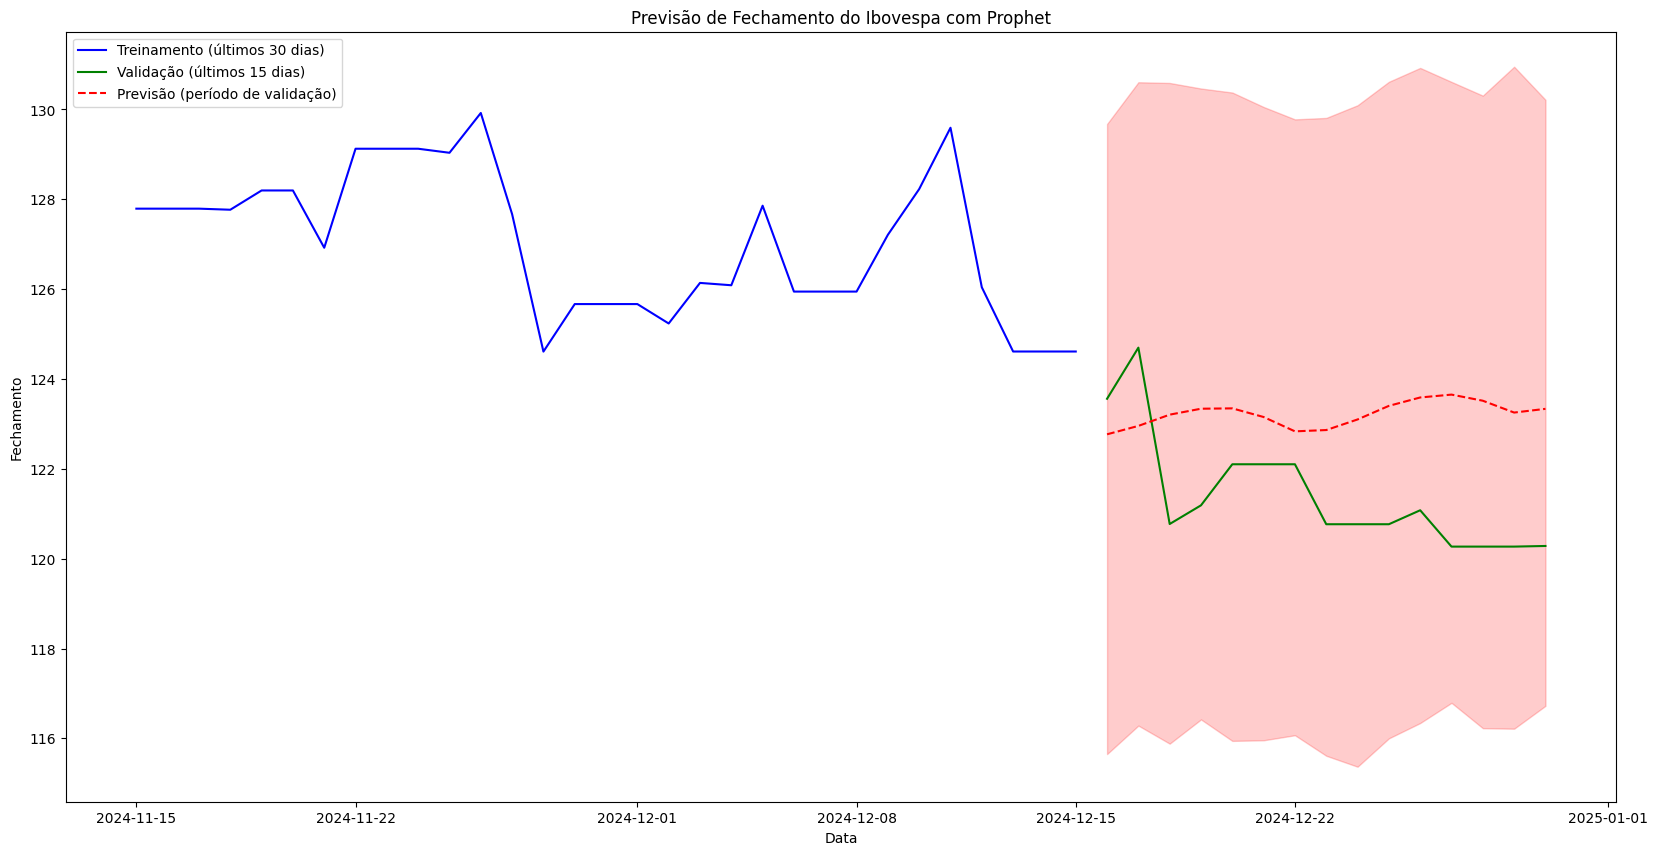

In [14]:
# Definir o número de dias para treinar o modelo antes de prever
train_days = len(historico_goog) - 15  # Pega os dados até 15 dias antes do fim do dataframe

# Divida os dados em treino e teste (últimos 15 dias)
train = historico_goog[:train_days]
test = historico_goog[train_days:]

# Treine o modelo com os dados de treino
m = Prophet()

# Adicionando regressores
for reg in ['std_abertura_5d', 'std_fechamento_5d', 'std_vol_5d', 'std_alta_5d', 'std_baixa_5d',
            'std_abertura_10d', 'std_fechamento_10d', 'std_vol_10d', 'std_alta_10d', 'std_baixa_10d']:
    m.add_regressor(reg)

# Remover valores nulos
train = train.dropna(subset=['std_vol_5d', 'std_vol_10d'])

# Ajustar o modelo com os dados de treino
m.fit(train)

# Criar dataframe com as datas futuras (15 dias à frente)
future = m.make_future_dataframe(periods=15)

# Adicionar os valores futuros dos regressores
last_row = train.iloc[-1]
for reg in ['std_abertura_5d', 'std_fechamento_5d', 'std_vol_5d', 'std_alta_5d', 'std_baixa_5d',
            'std_abertura_10d', 'std_fechamento_10d', 'std_vol_10d', 'std_alta_10d', 'std_baixa_10d']:
    future[reg] = last_row[reg]

# Prever os próximos 15 dias
forecast = m.predict(future)

# Calcular WMAPE
df_comparacao = pd.merge(forecast[['ds', 'yhat']], test[['ds', 'y']], on='ds', how='inner')
df_comparacao['abs_error'] = abs(df_comparacao['y'] - df_comparacao['yhat'])
wmape = df_comparacao['abs_error'].sum() / df_comparacao['y'].sum()

print(f"WMAPE para os últimos 15 dias: {wmape}")

# Filtrar os últimos 30 dias do treino
last_30_days = train['ds'].max() - pd.Timedelta(days=30)
train_subset = train[train['ds'] >= last_30_days]

# Filtrar previsões para o período de validação (últimos 15 dias)
forecast_validation = forecast[forecast['ds'].isin(test['ds'])]

# Gráfico
plt.figure(figsize=(20, 10))

# Dados históricos (últimos 30 dias do treino)
plt.plot(train_subset['ds'], train_subset['y'], label='Treinamento (últimos 30 dias)', color='blue')

# Dados de teste (validação)
plt.plot(test['ds'], test['y'], label='Validação (últimos 15 dias)', color='green')

# Previsão do modelo (somente período de validação)
plt.plot(forecast_validation['ds'], forecast_validation['yhat'], label='Previsão (período de validação)', color='red', linestyle='--')

# Intervalos de confiança (somente período de validação)
plt.fill_between(forecast_validation['ds'], forecast_validation['yhat_lower'], forecast_validation['yhat_upper'], color='red', alpha=0.2)

# Rótulos e título
plt.title('Previsão de Fechamento do Ibovespa com Prophet')
plt.xlabel('Data')
plt.ylabel('Fechamento')
plt.legend()

# Exibir o gráfico
plt.show()

In [19]:
# Calculando as métricas de avaliação
mae = mean_absolute_error(test['y'], forecast_validation['yhat'])
rmse = np.sqrt(mean_squared_error(test['y'], forecast_validation['yhat']))
mape = mean_absolute_percentage_error(test['y'], forecast_validation['yhat'])
mse = mean_squared_error(test['y'], forecast_validation['yhat'])
r2 = r2_score(test['y'], forecast_validation['yhat'])

# Exibindo as métricas
print(f'MAE: {mae}')
print(f'RMSE: {rmse}')
print(f'MAPE: {mape:.2f}%')
print(f"WMAPE para os últimos 15 dias: {wmape}")
print(f'MSE: {mse}')
print(f'R²: {r2}')

MAE: 2.159287331731115
RMSE: 2.319523116710507
MAPE: 0.02%
WMAPE para os últimos 15 dias: 0.01778661970472524
MSE: 5.380187488954423
R²: -2.38361480379298
